In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# global settings for the image style
plt.style.use('fivethirtyeight')
import itertools
import statsmodels.api as sm  # the library for SARIMA algorithm
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")  # great usage

# Data pre-processing

In [3]:
data = pd.read_csv("CGMData.csv")

In [4]:
from datetime import datetime
def stampToString(x):  
    d = datetime.fromtimestamp(x)
    return d.strftime("%m.%d.%Y %H:%M:%S")

stampToString(1529140800 + 25200)  

'06.16.2018 09:20:00'

In [5]:
values = [float(i) if np.isfinite(i) else 0 for i in data.values[0]]
# starting from 2018-06-16 09:20, every 5 minutes 
based_t = 1529140800 + 25200 # 2018-06-16 09:20
pairs = []
n_samples = 8640  # 2018-06-16 09:20 - 2018-07-16 09:15
print("len of the values:", len(values), ", n_sample is:", n_samples)
for i in range(n_samples):
    t = based_t + i * 300
    pairs.append((stampToString(t), values[i])) 

len of the values: 44845 , n_sample is: 8640


In [6]:
pairs = pd.DataFrame(data=pairs, columns=['Date', 'Sensor'])
pairs.Sensor = pairs.Sensor.astype(float)
pairs.tail()

Date  Sensor
8635  07.16.2018 08:55:00    93.0
8636  07.16.2018 09:00:00    92.0
8637  07.16.2018 09:05:00    88.0
8638  07.16.2018 09:10:00    83.0
8639  07.16.2018 09:15:00    80.0

In [7]:
pairs = pairs.set_index(['Date'])
pairs.index = pd.to_datetime(pairs.index)

# SARIMA model

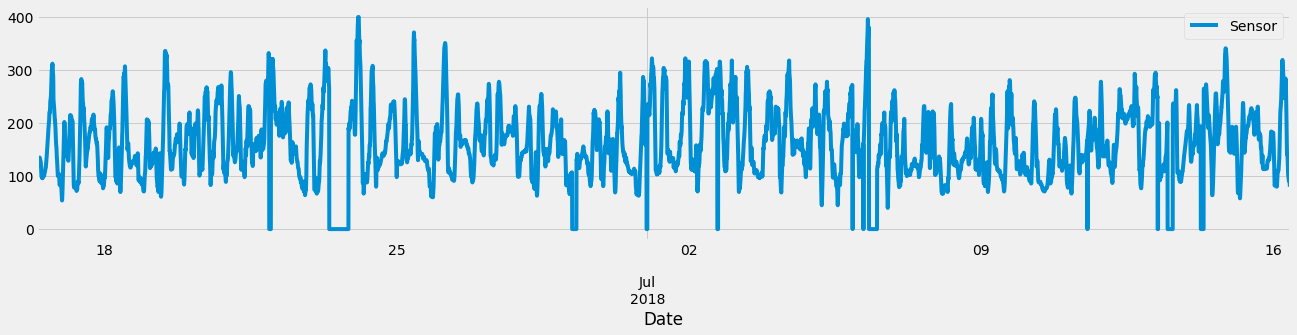

In [8]:
pairs.plot(figsize=(20, 4))
plt.show()

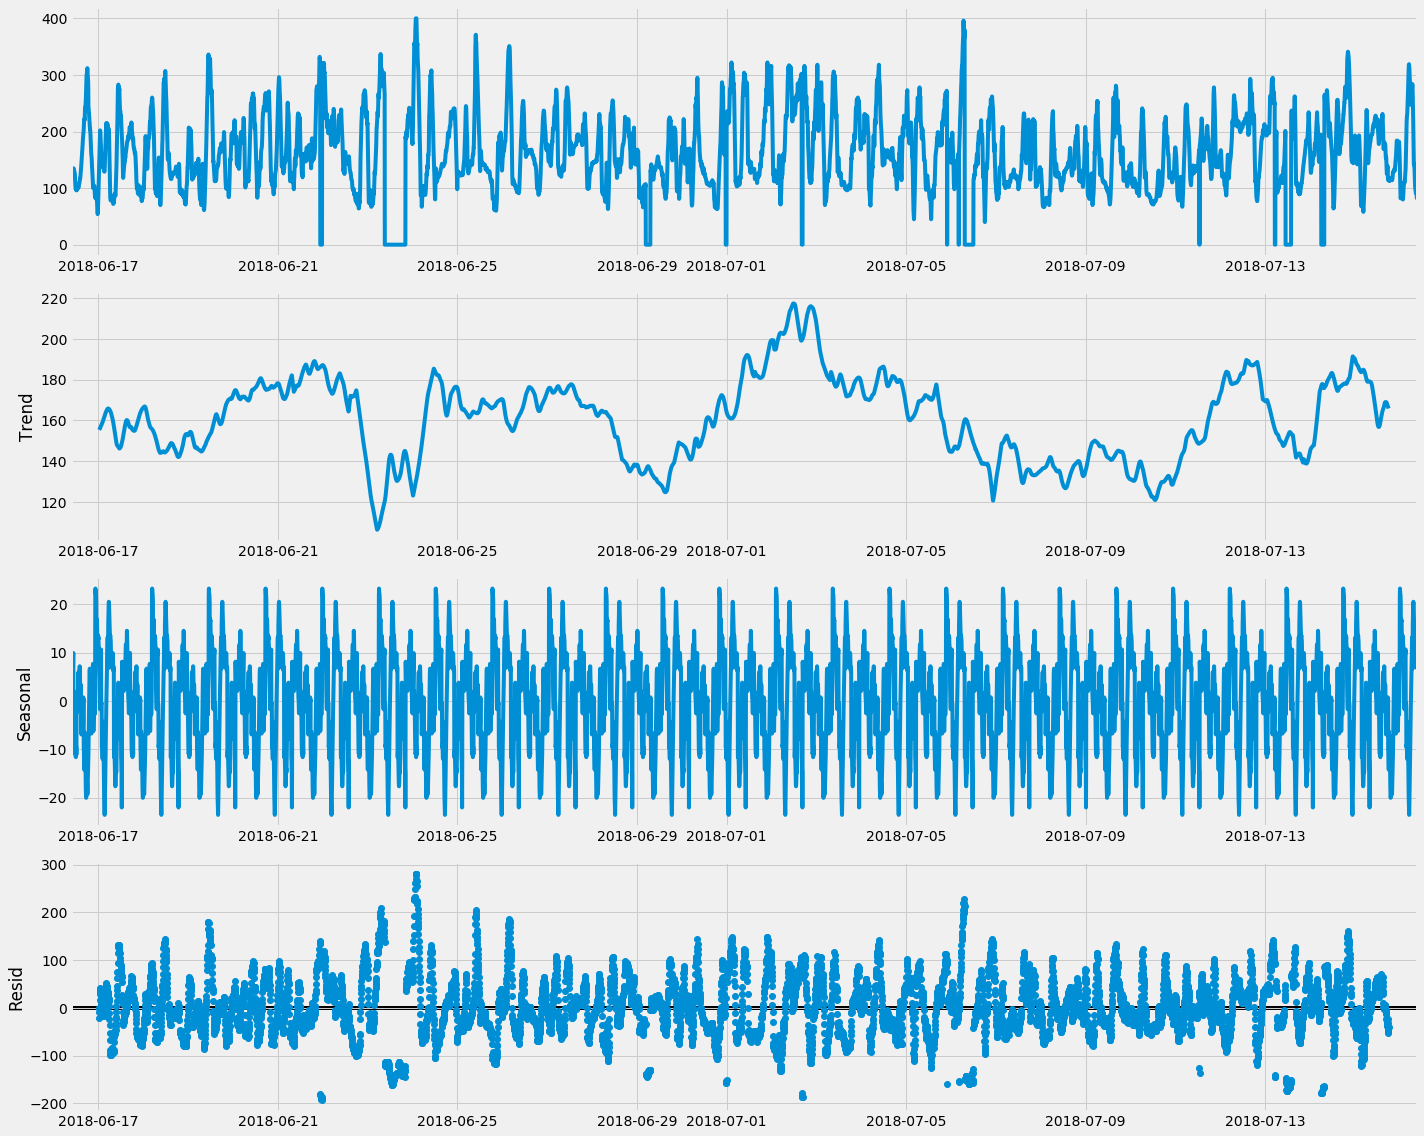

In [9]:
# freq = 364
decomposition = sm.tsa.seasonal_decompose(pairs, model='additive', frozenseteq=364)
rcParams['figure.figsize'] = 20, 16
fig = decomposition.plot()
plt.show()

In [10]:
# init the parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
product_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [11]:
AICs = []
for param in pdq:
    for param_seasonal in product_pdq:
        mod = sm.tsa.statespace.SARIMAX(pairs,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{} x {} - AIC:{}'.format(param, param_seasonal, results.aic))
        AICs.append(results.aic)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC:113729.40342534526
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC:105322.1910114853
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC:95197.37417974441
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC:95078.5155902397
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC:94947.63558588596
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC:94922.68573782379
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC:95088.70596515451
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC:95058.35239853419
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC:102373.94691415527
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC:94664.34401978336
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC:86124.56481507413
ARIMA(0, 0, 1) x (0, 1, 1, 12) - AIC:85919.48013962401
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC:85812.65432767058
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC:85769.81737699096
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC:85979.49094268179
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC:83947.27365966128
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:69584.51072035238
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:69486.0021684187
ARIMA(0, 1

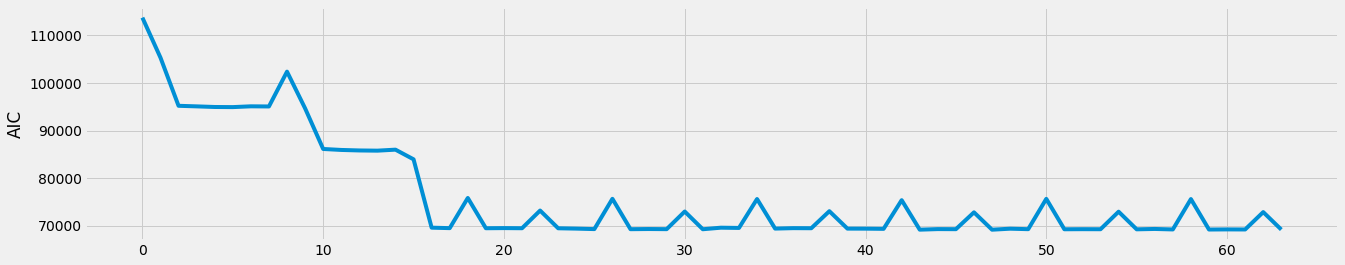

In [12]:
# draw the AIC curve
# distribution of all combinations
plt.figure(figsize=(20, 4))
plt.plot(AICs)
plt.ylabel('AIC')
plt.show()

In [13]:
# the best combination is: 1, 0, 1 and 1, 1, 1, 12
mod = sm.tsa.statespace.SARIMAX(pairs,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9755      0.003    314.546      0.000       0.969       0.982
ma.L1          0.1535      0.003     51.913      0.000       0.148       0.159
ar.S.L12      -0.0356      0.002    -16.020      0.000      -0.040      -0.031
ma.S.L12      -1.0000      1.067     -0.937      0.349      -3.092       1.092
sigma2       177.8477    189.924      0.936      0.349    -194.397     550.093


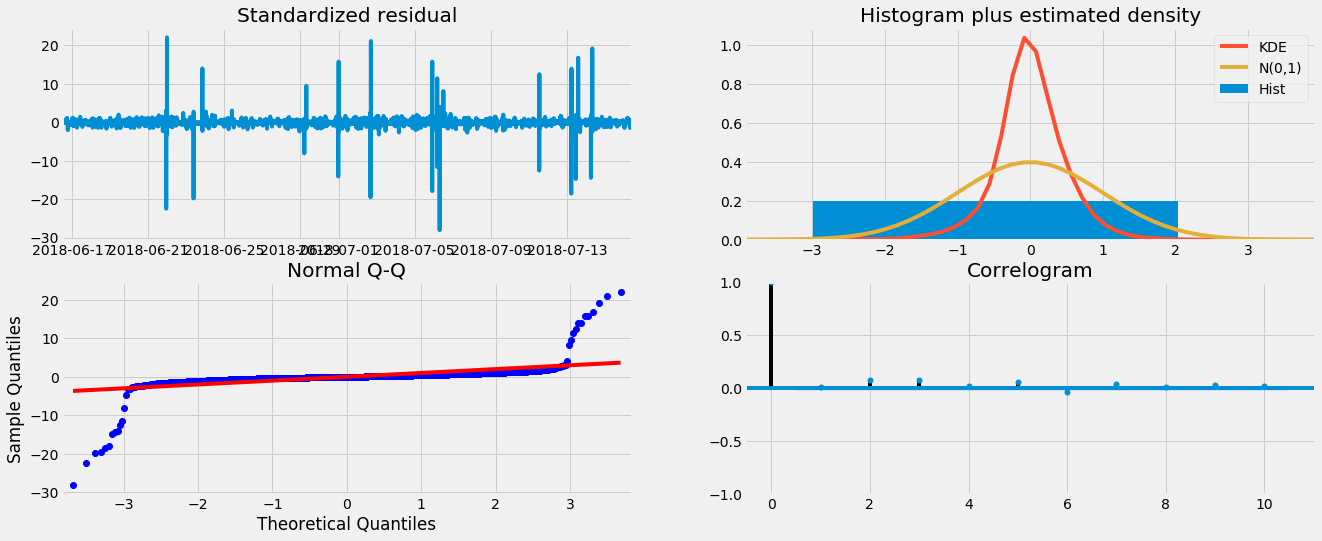

In [14]:
results.plot_diagnostics(figsize=(20, 8))
plt.show()

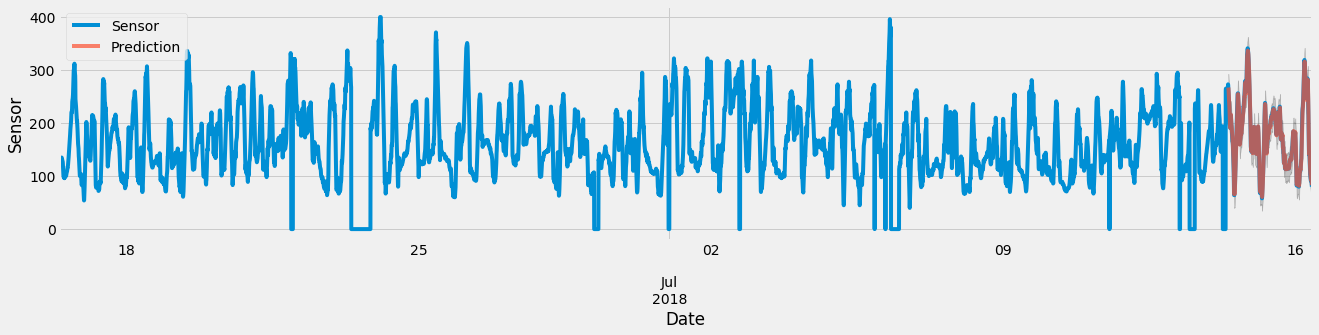

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2018-07-14 09:15:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = pairs.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sensor')
plt.legend()
plt.show()

In [16]:
# predict sensor data since 2018-07-14 09:15:00
ground_truth = pairs["2018-07-14 09:15:00":]
ground_truth.head()

Sensor
Date                       
2018-07-14 09:15:00   267.0
2018-07-14 09:20:00   261.0
2018-07-14 09:25:00   256.0
2018-07-14 09:30:00   250.0
2018-07-14 09:35:00   245.0

In [18]:
# sensor data >= 250 to take the meal
prediction = pred.predicted_mean
prediction.head(20)

2018-07-14 09:15:00    267.001954
2018-07-14 09:20:00    265.125780
2018-07-14 09:25:00    257.274096
2018-07-14 09:30:00    253.642585
2018-07-14 09:35:00    247.580573
2018-07-14 09:40:00    242.725056
2018-07-14 09:45:00    237.418950
2018-07-14 09:50:00    230.182850
2018-07-14 09:55:00    225.253097
2018-07-14 10:00:00    216.805953
2018-07-14 10:05:00    203.547494
2018-07-14 10:10:00    195.834983
2018-07-14 10:15:00    191.500380
2018-07-14 10:20:00    191.027397
2018-07-14 10:25:00    190.905611
2018-07-14 10:30:00    198.650553
2018-07-14 10:35:00    204.328047
2018-07-14 10:40:00    210.165578
2018-07-14 10:45:00    215.715022
2018-07-14 10:50:00    209.048112
Freq: 5T, dtype: float64

In [19]:
pred_ci.head(20)

lower Sensor  upper Sensor
2018-07-14 09:15:00    240.844412    293.159496
2018-07-14 09:20:00    238.968239    291.283322
2018-07-14 09:25:00    231.116572    283.431619
2018-07-14 09:30:00    227.485069    279.800101
2018-07-14 09:35:00    221.423057    273.738089
2018-07-14 09:40:00    216.567540    268.882571
2018-07-14 09:45:00    211.261435    263.576465
2018-07-14 09:50:00    204.025335    256.340365
2018-07-14 09:55:00    199.095582    251.410612
2018-07-14 10:00:00    190.648438    242.963468
2018-07-14 10:05:00    177.389979    229.705009
2018-07-14 10:10:00    169.677469    221.992497
2018-07-14 10:15:00    165.342867    217.657893
2018-07-14 10:20:00    164.869884    217.184909
2018-07-14 10:25:00    164.748116    217.063106
2018-07-14 10:30:00    172.493066    224.808040
2018-07-14 10:35:00    178.170560    230.485534
2018-07-14 10:40:00    184.008091    236.323064
2018-07-14 10:45:00    189.557536    241.872508
2018-07-14 10:50:00    182.890626    235.205598

In [20]:
mse = ((prediction.values - ground_truth.values) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))

The Mean Squared Error is 7617.86
